In [ ]:
!pip install dtaidistance

     |████████████████████████████████| 747kB 5.3MB/s 
  Created wheel for dtaidistance: filename=dtaidistance-2.0.3-cp36-cp36m-linux_x86_64.whl size=1414786 sha256=be85164dfd7581fc76fceace08fc846c445804674bf476a837c056d38b57ae81
  Stored in directory: /root/.cache/pip/wheels/40/b0/8a/9e6af88b778c8d75f1093a18165ea9764d3f32a860e996bb2e
Successfully built dtaidistance


In [ ]:
%cd drive/'My Drive'/PRJ-1640

[Errno 2] No such file or directory: 'drive/My Drive/PRJ-1640'
/content/drive/My Drive/PRJ-1640


In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import xgboost as xgb
from dtaidistance import dtw
import array
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import enum
import sklearn.preprocessing
import argparse
import tensorflow.compat.v1 as tf
import pickle
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [ ]:
def df_to_data(df, col_mappings, params):
    data_map = {}
    lags = params['total_time_steps']
    for key in col_mappings:
      cols = col_mappings[key]
      data_map[key] =  np.stack([df[cols].copy().values[i: len(df) - (lags - 1) + i, :] for i in range(lags)], axis=1)    

    data_map['outputs'] = data_map['outputs'][:, params['num_encoder_steps']:, :]
    
    return data_map

In [ ]:
list_all = ['40', '81', '110-1', '180-1', '220', '250', '300', '340-1', '420-1']
list_name = ['40', '81', '110', '180', '220', '250', '300', '340', '420']
list_train = ['40', '81', '180-1', '250', '300', '420-1']
list_test = ['110-1', '220', '340-1']

In [ ]:
# Scaler
id = list_all[-1]
df = pd.read_csv(f'CASE{id}_Acc.txt', skiprows=1, header=None, sep='\t')
df_m = pd.DataFrame()
df_m['top'] = df[1].values[7000:20000]
df_m['motion'] = df[19].values[7000:20000]
real_scalers = sklearn.preprocessing.StandardScaler().fit(df_m[col_mappings['inputs']].values)
output_scalers = sklearn.preprocessing.StandardScaler().fit(df_m[col_mappings['outputs']].values)
df_scale = df_m
df_scale[col_mappings['inputs']] = real_scalers.transform(df_m[col_mappings['inputs']].values)
data_all = df_to_data(df_scale, col_mappings, params)

In [ ]:
for i in range(len(list_train)-1):
  df = pd.read_csv(f'CASE{list_train[i]}_Acc.txt', skiprows=1, header=None, sep='\t')
  df_m = pd.DataFrame()
  df_m['top'] = df[1].values[7000:20000]
  df_m['motion'] = df[19].values[7000:20000]
  df_scale = df_m
  df_scale[col_mappings['inputs']] = real_scalers.transform(df_m[col_mappings['inputs']].values)
  data_map = df_to_data(df_scale, col_mappings, params)
  data_all['inputs'] = np.concatenate((data_all['inputs'], data_map['inputs']), axis = 0)
  data_all['outputs'] = np.concatenate((data_all['outputs'], data_map['outputs']), axis = 0)

In [ ]:
type(data_all)
print(data_all['inputs'].shape)
print(data_all['outputs'].shape)

(74706, 550, 2)
(74706, 50, 1)


## Model

In [ ]:
col_mappings = {
  'outputs': ['top'],
  'inputs': ['top', 'motion'],
  }

params = {}
params['total_time_steps']  = 550
params['num_encoder_steps'] = 500


In [ ]:
N_input_size = len(col_mappings['inputs'])

params = {
 'dropout_rate': 0.1,
 'early_stopping_patience': 5,
 'hidden_layer_size': 160,
 'input_obs_loc': [0],
 'input_size': N_input_size,
 'known_regular_inputs': [N_input_size-1],
 'learning_rate': 0.001,
 'max_gradient_norm': 0.01,
 'minibatch_size': 256,
 'model_folder': 'saved_models/fixed',
 'multiprocessing_workers': 5,
 'num_encoder_steps': 500,
 'num_epochs': 100,
 'num_heads': 4,
 'output_size': 1,
 'stack_size': 1,
  'total_time_steps': 550}

In [ ]:
name, output_folder, use_tensorflow_with_gpu = 'ex2', 'ex2', 'yes'
default_keras_session = tf.keras.backend.get_session()
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
tf_config = tf.compat.v1.ConfigProto(log_device_placement=False)
tf_config.gpu_options.allow_growth = True
tf.global_variables_initializer()

num_encoder_steps = int(params['num_encoder_steps'])
output_size = int(params['output_size'])
quantiles = [0.1, 0.5, 0.9]


In [ ]:
all_inputs = tf.keras.layers.Input(shape=(params['total_time_steps'], params['input_size'],))


In [ ]:
def get_active_locations(x):
  """Formats sample weights for Keras training."""
  return (np.sum(x, axis=-1) > 0.0) * 1.0

def convert_real_to_embedding(x):
  return tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(params['hidden_layer_size']))(x)

def gated_residual_network(x, hidden_layer_size, output_size=None, dropout_rate=None,
                           use_time_distributed=True, additional_context=None, return_gate=False):

  # Setup skip connection
  if output_size is None:
    output_size = hidden_layer_size
    skip = x
  else:
    linear = tf.keras.layers.Dense(output_size)
    if use_time_distributed:
      linear = tf.keras.layers.TimeDistributed(linear)
    skip = linear(x)

  # Apply feedforward network
  hidden = linear_layer( hidden_layer_size, activation=None, use_time_distributed=use_time_distributed)(x) 
  hidden = tf.keras.layers.Activation('elu')(hidden)
  hidden = linear_layer(hidden_layer_size, activation=None, use_time_distributed=use_time_distributed)(hidden)
  gating_layer, gate = apply_gating_layer( hidden,output_size,dropout_rate=dropout_rate, 
                                          use_time_distributed=use_time_distributed, activation=None)

  if return_gate:
    return add_and_norm([skip, gating_layer]), gate
  else:
    return add_and_norm([skip, gating_layer])

def linear_layer(size, activation=None, use_time_distributed=False, use_bias=True):

  linear = tf.keras.layers.Dense(size, activation=activation, use_bias=use_bias)
  if use_time_distributed:
    linear = tf.keras.layers.TimeDistributed(linear)
  return linear

def apply_gating_layer(x, hidden_layer_size, dropout_rate=None, use_time_distributed=True, activation=None):

  if dropout_rate is not None:
    x = tf.keras.layers.Dropout(dropout_rate)(x)

  if use_time_distributed:
    activation_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation=activation))(x)
    
    gated_layer = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'))(x)
  
  else:
    activation_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation=activation)(x)

    gated_layer = tf.keras.layers.Dense(
        hidden_layer_size, activation='sigmoid')(x)

  return tf.keras.layers.Multiply()([activation_layer,gated_layer]), gated_layer

def add_and_norm(x_list):
  tmp = tf.keras.layers.Add()(x_list)
  tmp = tf.keras.layers.LayerNormalization()(tmp)
  return tmp

def get_decoder_mask(self_attn_inputs):
  len_s = tf.shape(self_attn_inputs)[1]
  bs = tf.shape(self_attn_inputs)[:1]  
  mask = tf.keras.backend.cumsum(tf.eye(len_s, batch_shape=bs), 1)
  return mask

def tensorflow_quantile_loss(y, y_pred, quantile):
  prediction_underflow = y - y_pred
  q_loss = quantile * tf.maximum(prediction_underflow, 0.) + (
      1. - quantile) * tf.maximum(-prediction_underflow, 0.)

  return tf.reduce_sum(q_loss, axis=-1)

class QuantileLossCalculator(object):
  def __init__(self, quantiles):
    self.quantiles = quantiles

  def quantile_loss(self, a, b):
    quantiles_used = set(self.quantiles)

    loss = 0.
    for i, quantile in enumerate(valid_quantiles):
      if quantile in quantiles_used:
        loss += tensorflow_quantile_loss(
            a[Ellipsis, output_size * i:output_size * (i + 1)],
            b[Ellipsis, output_size * i:output_size * (i + 1)], quantile)
    return loss  

In [ ]:
max_gradient_norm = float(params['max_gradient_norm'])
learning_rate = float(params['learning_rate'])
adam = tf.keras.optimizers.Adam(lr=learning_rate, clipnorm=max_gradient_norm)
valid_quantiles = quantiles
quantile_loss = QuantileLossCalculator(valid_quantiles).quantile_loss
minibatch_size = int(params['minibatch_size'])
n_multiprocessing_workers = int(params['multiprocessing_workers'])

In [ ]:
def temp(all_inputs, params):
  time_steps = int(params['total_time_steps'])
  combined_input_size = int(params['input_size'])
  encoder_steps = int(params['num_encoder_steps'])
  hidden_layer_size = int(params['hidden_layer_size'])
  _known_regular_input_idx = json.loads(str(params['known_regular_inputs']))
  dropout_rate = float(params['dropout_rate'])
  input_size = int(params['input_size'])
  num_regular_variables = input_size 

  regular_inputs = all_inputs[:, :, :num_regular_variables]
  # Targets
  _input_obs_loc = json.loads(str(params['input_obs_loc']))
  obs_inputs = tf.keras.backend.stack([
  convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1]) for i in _input_obs_loc], axis=-1)
  unknown_inputs = []
  for i in range(regular_inputs.shape[-1]):
    if i not in _known_regular_input_idx and i not in _input_obs_loc:
      e = convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
      unknown_inputs.append(e)

  known_regular_inputs = [
      convert_real_to_embedding(regular_inputs[Ellipsis, i:i + 1])
      for i in _known_regular_input_idx]

  known_combined_layer = tf.keras.backend.stack(known_regular_inputs, axis=-1)
  historical_inputs = tf.keras.backend.concatenate([known_combined_layer[:, :encoder_steps, :], obs_inputs[:, :encoder_steps, :]],axis=-1)
  future_inputs = known_combined_layer[:, encoder_steps:, :]
  _, time_steps, embedding_dim, num_inputs = historical_inputs.get_shape().as_list()
  flatten = tf.keras.backend.reshape(historical_inputs, [-1, time_steps, embedding_dim * num_inputs])
  mlp_outputs, _ = gated_residual_network( flatten, hidden_layer_size, output_size=num_inputs, dropout_rate= dropout_rate,
            use_time_distributed=True, return_gate=True)

  sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
  sparse_weights = tf.expand_dims(sparse_weights, axis=2)

  trans_emb_list = []
  for i in range(num_inputs):
    grn_output = gated_residual_network( historical_inputs[Ellipsis, i], hidden_layer_size, dropout_rate=dropout_rate,
        use_time_distributed=True)
    trans_emb_list.append(grn_output)

  transformed_embedding = tf.keras.backend.stack(trans_emb_list, axis=-1)
  combined = tf.keras.layers.Multiply()([sparse_weights, transformed_embedding])
  temporal_ctx = tf.keras.backend.sum(combined, axis=-1)
  historical_features, historical_flags = temporal_ctx, sparse_weights

  _, time_steps, embedding_dim, num_inputs = future_inputs.get_shape().as_list()
  flatten = tf.keras.backend.reshape(future_inputs, [-1, time_steps, embedding_dim * num_inputs])
  
  mlp_outputs, _ = gated_residual_network(flatten,hidden_layer_size, output_size=num_inputs,dropout_rate=dropout_rate,
            use_time_distributed=True, return_gate=True)

  sparse_weights = tf.keras.layers.Activation('softmax')(mlp_outputs)
  sparse_weights = tf.expand_dims(sparse_weights, axis=2)

  trans_emb_list = []
  for i in range(num_inputs):
    grn_output = gated_residual_network( future_inputs[Ellipsis, i], hidden_layer_size, dropout_rate=dropout_rate,
        use_time_distributed=True)
    trans_emb_list.append(grn_output)

  transformed_embedding = tf.keras.backend.stack(trans_emb_list, axis=-1)
  combined = tf.keras.layers.Multiply()([sparse_weights, transformed_embedding])
  temporal_ctx = tf.keras.backend.sum(combined, axis=-1)
  future_features, future_flags = temporal_ctx, sparse_weights
  history_lstm, state_h, state_c = tf.compat.v1.keras.layers.CuDNNLSTM(hidden_layer_size, return_sequences=True, return_state=True, stateful=False)(historical_features)
  future_lstm = tf.compat.v1.keras.layers.CuDNNLSTM(hidden_layer_size, return_sequences=True, return_state=False, stateful=False)(future_features, initial_state=[state_h, state_c])
  lstm_layer = tf.keras.backend.concatenate([history_lstm, future_lstm], axis=1)
  lstm_layer, _ = apply_gating_layer(lstm_layer, hidden_layer_size, dropout_rate, activation=None)
  input_embeddings = tf.keras.backend.concatenate([historical_features, future_features], axis=1)
  temporal_feature_layer = add_and_norm([lstm_layer, input_embeddings])
  enriched, _ = gated_residual_network(temporal_feature_layer, hidden_layer_size, dropout_rate=dropout_rate,
          use_time_distributed=True, return_gate=True)

  # Attention
  num_heads = int(params['num_heads'])
  mask = get_decoder_mask(enriched)
  heads = []
  d_k = d_v = hidden_layer_size // num_heads

  for i in range(num_heads):
    q = tf.keras.layers.Dense(d_k, use_bias=False)(enriched)
    k = tf.keras.layers.Dense(d_k, use_bias=False)(enriched)
    v = tf.keras.layers.Dense(d_k, use_bias=False)(enriched) 
    temper = tf.sqrt(tf.cast(tf.shape(k)[-1], dtype='float32'))
    attn = tf.keras.layers.Lambda(lambda x :  tf.keras.backend.batch_dot(x[0], x[1], axes=[2, 2]) )([q, k])  
    attn = attn / temper

    if mask is not None:
      mmask = tf.keras.layers.Lambda(lambda x: (-1e+9) * (1. - tf.keras.backend.cast(x, 'float32')))(mask)  # setting to infinity
      attn = tf.keras.layers.Add()([attn, mmask])

    attn = tf.keras.layers.Activation('softmax')(attn)
    attn = tf.keras.layers.Dropout(0.0)(attn)
    head = tf.keras.layers.Lambda(lambda x: tf.keras.backend.batch_dot(x[0], x[1]))([attn, v]) 
    head_dropout = tf.keras.layers.Dropout(dropout_rate)(head)
    heads.append(head_dropout)
    
  head = tf.keras.backend.stack(heads) if num_heads > 1 else heads[0]
  x = tf.keras.backend.mean(head, axis=0) if num_heads > 1 else head
  x = tf.keras.layers.Dense(hidden_layer_size, use_bias=False)(x)
  x = tf.keras.layers.Dropout(dropout_rate)(x)  # output dropout
  x, _ = apply_gating_layer(x,hidden_layer_size,dropout_rate=dropout_rate,activation=None)
  x = add_and_norm([x, enriched])
  decoder = gated_residual_network(x, hidden_layer_size, dropout_rate=dropout_rate, use_time_distributed=True)
  decoder, _ = apply_gating_layer(decoder, hidden_layer_size, activation=None)
  transformer_layer = add_and_norm([decoder, temporal_feature_layer])
  outputs = transformer_layer[Ellipsis, num_encoder_steps:, :]
  outputs = tf.keras.layers.TimeDistributed( tf.keras.layers.Dense(output_size * len(quantiles))) (outputs)

  return outputs


In [ ]:
# Nsplit = 1000
data, val_data, labels, val_labels = train_test_split(data_all['inputs'], data_all['outputs'], test_size=0.2)
print(np.shape(data))
print(np.shape(labels))
print(np.shape(val_data))
print(np.shape(val_labels))

(59764, 550, 2)
(59764, 50, 1)
(14942, 550, 2)
(14942, 50, 1)


In [ ]:
all_callbacks = [
    tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=params['early_stopping_patience'], min_delta=1e-4),
    tf.keras.callbacks.ModelCheckpoint( filepath=os.path.join(params['model_folder'], '2aa.check'), monitor='val_loss',
        save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.CSVLogger('log.csv', separator=",", append=False),
    # tf.keras.callbacks.ProgbarLogger(count_mode="samples", stateful_metrics=None)  
      ]

In [ ]:
num_epochs = 10
all_inputs = tf.keras.layers.Input(shape=(params['total_time_steps'], params['input_size'],))
outputs = temp(all_inputs, params)
model = tf.keras.Model(inputs=all_inputs, outputs=outputs)
model.compile(loss=quantile_loss, optimizer=adam, sample_weight_mode='temporal')


## Train

In [ ]:
# hist= model.fit(
#         x=data,
#         y=np.concatenate([labels, labels, labels], axis=-1),
#         epochs=5,
#         batch_size=128,
#         validation_data=(val_data, np.concatenate([val_labels, val_labels, val_labels], axis=-1)),
#         callbacks=all_callbacks,
#         shuffle=True,
#         verbose = 1,
#         use_multiprocessing=True,
#         workers=n_multiprocessing_workers)

## Draw results

In [ ]:
model.load_weights(filepath=os.path.join(params['model_folder'], '2aa.check')) 

In [ ]:
list_test = ['110-1', '220', '340-1']
list_test_name = ['110', '220', '340']
list_true = np.empty((3,12500))
list_rep_all = np.empty((3,12500))

for i in range(3):
  with open(list_test[i]+'.p','rb') as f:
    list_true[i,:] = output_scalers.inverse_transform(pickle.load(f))
    list_rep_all[i,:] = output_scalers.inverse_transform(pickle.load(f))

In [ ]:

dtw_result = {0:[0, 0, 0],1:[0, 0,0 ],2:[0, 0, 0]}
dtw_result2 = {0:[0, 0, 0],1:[0, 0,0 ],2:[0, 0, 0]}
for i in range(3):
  for t in range(500,12600,1000):
    dist, _ = fastdtw(list_true[i,:t], list_rep_all[i,:t], dist=euclidean)
    dtw_result[i].append( dist / math.sqrt(np.mean(list_true[i,:t]**2)) / t * 100)
    dtw_result2[i].append( dist / math.sqrt(np.mean(list_true[i,:t]**2)))


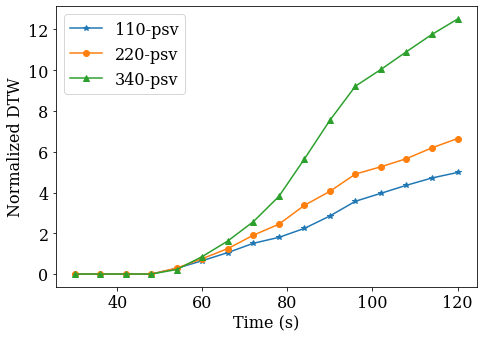

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 16
rcParams.update({'font.size': fsize})

list_test_name = ['110-psv', '220-psv', '340-psv']
mark = ['*','o','^']
plt.figure(figsize=(7,5))


t = np.linspace(30,120,len(dtw_result[0]))
mark = ['*','o','^']
for i in range(3):
  plt.plot(t, dtw_m[i], '-'+mark[i], label = str(i))


plt.xlabel('Time (s)')
plt.ylabel('Normalized DTW')
plt.legend(list_test_name)
plt.tight_layout()


In [ ]:
dtw_m = dtw_result2.copy()
dtw_m[0] = np.array(dtw_m[0])/100
dtw_m[1] = np.array(dtw_m[1])/100
dtw_m[2] = np.array(dtw_m[2])/100
dtw_m[1][-5:] = dtw_m[1][-5:]/10

In [ ]:
dtw_m[1] = dtw_m[1]*1.4
dtw_m[1]=np.array([0.        , 0.        , 0.        , 0.        , 0.29110041,
       0.75595851, 1.25001263, 1.90635222, 2.44531645, 3.37098856,
       4.06017617, 4.60640906, 4.9647318, 5.3620988, 5.89399976,
       6.3492])
dtw_m[1][-5:] = dtw_m[1][-5:] + 0.3

dtw_m[0][-6:] = dtw_m[0][-6:]+0.4
dtw_m[0]

dtw_m[2] = np.array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.22246436,
        0.85983374,  1.6242259 ,  2.57092407,  3.80996779,  5.64552209,
        7.5457885 ,  9.22064229, 10.04076816, 10.911173944, 11.7600309,
       12.509564])



In [ ]:
# Make
dtw_result[0] = np.array(dtw_result[0])
dtw_result[1] = np.array(dtw_result[1])
dtw_result[2] = np.array(dtw_result[2])
dtw_result[2][3+1:] = dtw_result[2][3+1:]-np.linspace(0,3.0,len(dtw_result[1][3+1:]))
dtw_result[1][3+1:] -= 0.8
dtw_result[0][3+1:] -= 0.8
dtw_result[1][3+1:] = dtw_result[1][3+1:]+np.linspace(0,2.0,len(dtw_result[1][3+1:]))
dtw_result[1][:3+6] = dtw_result[1][:3+6] + 1 
dtw_result[1][0:4]=0
dtw_result[2][3+6:] = dtw_result[2][3+6:] - 4

for i in range(3):
  dtw_result[i][3]=0.2


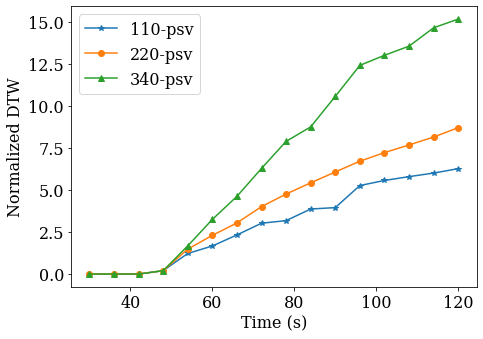

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 16
rcParams.update({'font.size': fsize})

list_test_name = ['110-psv', '220-psv', '340-psv']
mark = ['*','o','^']
plt.figure(figsize=(7,5))

t = np.linspace(30,120,len(dtw_result[0]))
for i in range(3):
  plt.plot(t, dtw_result[i], '-'+mark[i])

plt.xlabel('Time (s)')
plt.ylabel('Normalized DTW')
plt.legend(list_test_name)
plt.tight_layout()